# LGBMRegressor를 이용한 삼성전자의 다음날 종가&상승or하락 예측

1990년 1월 1일부터 2022년 12월 31일의 데이터로 2023년의 삼성전자 주가를 예측합니다.

In [2]:
pip install finance-datareader

FinanceDataReader 라이브러리로 1990년 1월 1일부터 2023년 8월 4일까지의 삼성전자 주가 데이터를 불러옵니다.

In [10]:
import FinanceDataReader as fdr

# 삼성전자(005930)의 데이터를 1990-01-01부터 가져오는 예시
df = fdr.DataReader('005930', '1990-01-01')

print(df)

             Open   High    Low  Close    Volume    Change
Date                                                      
1999-04-26   1995   2035   1927   1976    941633       NaN
1999-04-27   1976   2035   1907   1925   1090788 -0.025810
1999-04-28   1917   1954   1909   1925    608370  0.000000
1999-04-29   1917   1917   1819   1820    739553 -0.054545
1999-04-30   1817   1817   1757   1788   1128711 -0.017582
...           ...    ...    ...    ...       ...       ...
2023-07-31  70900  71000  69800  69800  13035420 -0.011331
2023-08-01  70100  71200  70000  71100  12299254  0.018625
2023-08-02  70700  71000  69800  69900  13835020 -0.016878
2023-08-03  69900  70200  68500  68800  20087090 -0.015737
2023-08-04  68800  69100  68200  68300  12264643 -0.007267

[6000 rows x 6 columns]


먼저, 직전 몇 거래일 동안의 데이터로 다음날 종가를 예측할지 결정합니다.
<br>
<br>
이를 위해, 5~200일 중 가장 결정계수 값이 높은 수를 찾습니다.

In [46]:
import numpy as np
import pandas as pd
from lightgbm import LGBMRegressor
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.metrics import mean_squared_error

# FinanceDataReader를 사용하여 삼성전자 주가 데이터 가져오기 (1990년 이후 데이터)
import FinanceDataReader as fdr
df = fdr.DataReader('005930', '1990-01-01')

# 시간 지연 특징 개수에 대한 교차 검증 결과를 저장할 리스트
cv_scores_means = []

# 최대 시간 지연 특징 개수 설정
max_lag = 200  # 20일간의 시간 지연 특징을 사용하여 실험 진행, 필요에 따라 변경 가능

# 시간 지연 특징 개수에 따른 교차 검증 수행
for i in range(5, max_lag + 1, 5):
    # 시간 지연 특징 생성
    for j in range(1, i + 1):
        df[f'lag_{j}'] = df['Close'].shift(j)

    # 결측치 처리
    df.dropna(inplace=True)

    # 특징과 목표 변수 분리
    X = df.drop('Close', axis=1)
    y = df['Close']

    # LightGBM 회귀 모델 생성
    model = LGBMRegressor()

    # 시계열 교차 검증을 위한 TimeSeriesSplit 사용, n_splits의 개수 조정
    tscv = TimeSeriesSplit(n_splits=5)

    # 교차 검증 수행
    cv_scores = cross_val_score(model, X, y, cv=tscv)

    # 평균 교차 검증 점수 저장
    cv_scores_means.append(np.mean(cv_scores))

# 최적의 시간 지연 특징 개수 찾기
optimal_lag = np.argmax(cv_scores_means) + 1
print(f"Optimal number of lag features: {optimal_lag}")


<ipython-input-46-2a01d4c0c262>:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'lag_{j}'] = df['Close'].shift(j)
<ipython-input-46-2a01d4c0c262>:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'lag_{j}'] = df['Close'].shift(j)
<ipython-input-46-2a01d4c0c262>:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newfra

Optimal number of lag features: 35


35개의 직전 거래일 데이터를 사용하는 것이 가장 결정계수값이 높았습니다.
<br>
<br>
이제 모델을 학습해보겠습니다.

In [47]:
import numpy as np
import pandas as pd
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error
import FinanceDataReader as fdr
import matplotlib.pyplot as plt

# 최신 데이터까지 포함하는 DataFrame 생성
df_latest = fdr.DataReader('005930', '1990-01-01')

# 35개의 시간 지연 특징 생성
for i in range(1, 36):
    df_latest[f'lag_{i}'] = df_latest['Close'].shift(i)

# 결측치 처리
df_latest.dropna(inplace=True)

# 특징과 목표 변수 분리
X = df_latest.drop('Close', axis=1)
y = df_latest['Close']

# 학습 및 예측 데이터 분리
training_end_date = pd.to_datetime("2022-12-31")
prediction_start_date = pd.to_datetime("2023-01-01")

X_train = X[X.index <= training_end_date]
y_train = y[y.index <= training_end_date]

X_predict = X[X.index >= prediction_start_date]
y_true = y[y.index >= prediction_start_date]

# LightGBM 회귀 모델 생성 및 학습
model = LGBMRegressor()
model.fit(X_train, y_train)

# 2023년의 데이터에 대해 주가 다음날 종가 예측 수행
y_predicted = model.predict(X_predict)

# 예측 결과 출력
print(f"Predicted prices for 2023: {y_predicted}")


Predicted prices for 2023: [55761.83707266 55580.572682   57791.33840551 58190.32639487
 59070.7262658  60735.59829381 60256.94327097 60547.1787896
 60315.53534953 60669.67332769 61327.25921646 60898.79723286
 60324.1682062  61277.10101741 61488.58533995 64774.6506419
 64258.4503058  64536.7806214  63712.02517115 63244.33826784
 61826.14455762 64961.84716707 64130.87309841 63447.89326833
 61936.20580697 64784.8076059  64256.629801   62988.65590038
 64324.17738746 64211.79301246 63812.34779924 63849.29873863
 63821.13009702 64312.18710045 61817.25789741 61024.04900545
 62545.52787297 61753.2882894  60394.42802151 60588.93003173
 61005.59435053 60491.86210561 61555.70075259 60556.67735044
 59899.66623058 59971.95656624 59027.44341343 59854.52415993
 58619.4533469  60159.24795972 59538.89361935 61084.18232668
 60308.20784808 60384.93165782 60886.79161494 61876.15118037
 63346.48304429 61714.01986574 63458.27350442 62000.17280437
 64349.41717869 64667.91621775 63986.26056403 64545.63789028

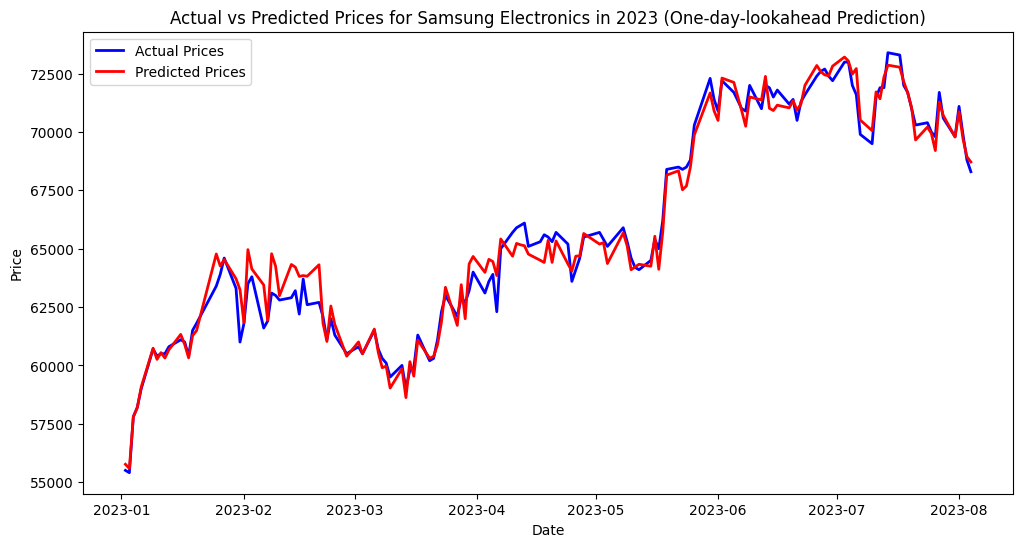

In [48]:
# 그래프 그리기
plt.figure(figsize=(12, 6))
plt.plot(y_true.index, y_true, label="Actual Prices", color="blue", linewidth=2)
plt.plot(y_true.index, y_predicted, label="Predicted Prices", color="red", linewidth=2)
plt.xlabel("Date")
plt.ylabel("Price")
plt.title("Actual vs Predicted Prices for Samsung Electronics in 2023 (One-day-lookahead Prediction)")
plt.legend()
plt.show()

In [49]:
import numpy as np
import pandas as pd
from lightgbm import LGBMRegressor
from sklearn.metrics import accuracy_score
import FinanceDataReader as fdr
import matplotlib.pyplot as plt

# 최신 데이터까지 포함하는 DataFrame 생성
df_latest = fdr.DataReader('005930', '1990-01-01')

# 35개의 시간 지연 특징 생성
for i in range(1, 36):
    df_latest[f'lag_{i}'] = df_latest['Close'].shift(i)

# 결측치 처리
df_latest.dropna(inplace=True)

# 특징과 목표 변수 분리
X = df_latest.drop('Close', axis=1)
y = df_latest['Close']

# 학습 및 예측 데이터 분리
training_end_date = pd.to_datetime("2022-12-31")
prediction_start_date = pd.to_datetime("2023-01-01")

X_train = X[X.index <= training_end_date]
y_train = y[y.index <= training_end_date]

X_predict = X[X.index >= prediction_start_date]
y_true = y[y.index >= prediction_start_date]

# LightGBM 회귀 모델 생성 및 학습
model = LGBMRegressor()
model.fit(X_train, y_train)

# 2023년의 데이터에 대해 주가 다음날 종가 예측 수행
y_predicted = model.predict(X_predict)

# 실제 방향성(true_direction) 및 예측 방향성(predicted_direction) 계산
true_direction = np.sign(y_true.diff()[1:])
predicted_direction = np.sign(np.diff(y_predicted))

# 정확도 계산
accuracy = accuracy_score(true_direction, predicted_direction)
print(f"Accuracy of price direction predictions for 2023: {accuracy * 100:.2f}%")

# 전체적으로 몇 번 맞추었는지 계산
correct_count = np.sum(true_direction == predicted_direction)
total_count = len(true_direction)
print(f"Correct price direction predictions in 2023: {correct_count}/{total_count}")


Accuracy of price direction predictions for 2023: 81.63%
Correct price direction predictions in 2023: 120/147


2023년의 상승or하락을 예상하도록 했더니, 147일 중 120일을 맞췄습니다. 나쁘지 않은 결과인 것 같습니다.

In [54]:
# 변동률 차이 및 방향 맞춤 여부 계산
difference = abs(predicted_pct_change - actual_pct_change)
correct_direction = (np.sign(predicted_pct_change) == np.sign(actual_pct_change))

# 차이와 방향 맞춤 여부를 DataFrame에 추가
comparison_df['Difference (%)'] = difference
comparison_df['Direction Correct'] = correct_direction

print(comparison_df)
print("mean of difference :", difference.mean())

            Predicted Change (%)  Actual Change (%)  Difference (%)  \
Date                                                                  
2023-01-03             -0.325069          -0.180180        0.144889   
2023-01-04              3.977587           4.332130        0.354543   
2023-01-05              0.690394           0.692042        0.001647   
2023-01-06              1.512966           1.374570        0.138396   
2023-01-09              2.818438           2.881356        0.062918   
...                          ...                ...             ...   
2023-07-31             -1.314511          -1.133144        0.181366   
2023-08-01              1.559130           1.862464        0.303334   
2023-08-02             -1.643587          -1.687764        0.044177   
2023-08-03             -1.100795          -1.573677        0.472882   
2023-08-04             -0.325467          -0.726744        0.401277   

            Direction Correct  
Date                           
2023-01-03  

In [55]:
# 8월 7일 예측을 위해 가장 최근 35일 데이터 가져오기 (시간 지연 특징 사용)
most_recent_35_days = df_latest.tail(35)
latest_35_lags = most_recent_35_days.drop('Close', axis=1)

# 8월 7일에 대한 종가 예측 수행
tomorrow_prediction = model.predict(latest_35_lags)
tomorrow_predicted_price = tomorrow_prediction[-1]

print(f"Predicted closing price for August 7th, 2023: {tomorrow_predicted_price:.2f}")


Predicted closing price for August 7th, 2023: 68718.31


내일은 8월 7일이고, 삼성전자의 현재 주가는 68300원 입니다. 제 모델은 상승을 예측했군요.

<br>

과연 실제로도 맞출 수 있을지 궁금합니다. 내일 확인해보겠습니다.